# Advanced Lane Detection

## Steps for Project
    1. Calibrate Camera using calibration matrix and distortion coefficients for given chessboard images
    2. Define a Undistortion ultility which undistors any frame of vide using calibration from step #1.
    3. Use perspective transform to get birds eye view of the image.
    4. Create a binary thresold image using sobel, color spaces techiniques taught in lesson.
    5. Find lanes.
    6. Determine curvature of the road.
    7. Unwrap the image back to original shape.
    8. Draw visual display of the lane detected


In [1]:
# Define all imports upfront
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
import random

# Our utils
from im_utils import read_image, convert_gray
from binary_thresholds import mag_thresh, dir_threshold, r_threshold, s_hls_threshold, l_hls_threshold, \
yellow_threshold, white_threshold

## Step 1: Calibrate camera

### 1.1 Explore Calbiraton images

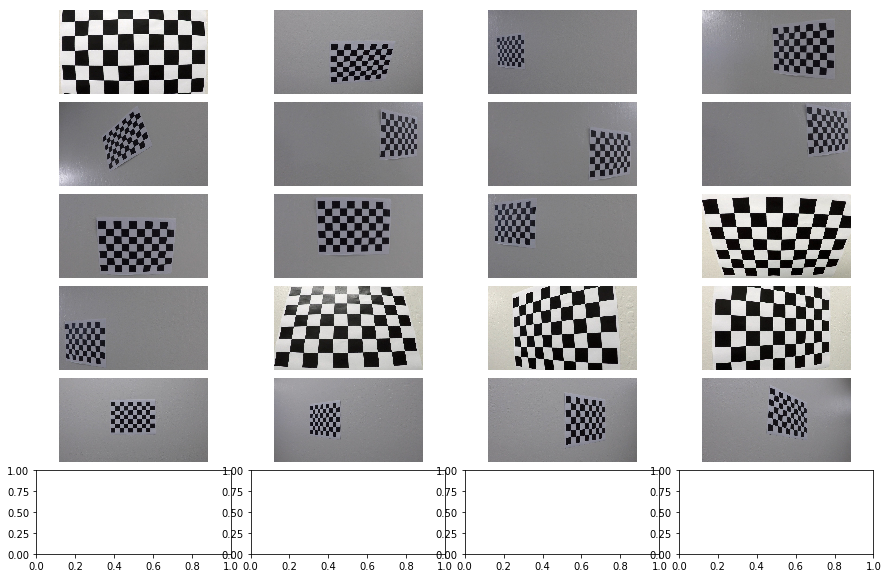

In [2]:
cal_fnames = glob.glob('./camera_cal/calibration*.jpg')

# Explore all images in a 5X4 grid.
def plot_images(images):
    # Plot 4 images per row
    fig, axs = plt.subplots(int(len(images) / 4) + 1, 4, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i, img in enumerate(images):
        axs[i].axis('off')
        axs[i].imshow(img)

        
def explore_calibration_images():
    images = []
    for i, cal_fname in enumerate(cal_fnames):
        img = read_image(cal_fname)
        images.append(img)

    plot_images(images)
    

explore_calibration_images()    
    

### 1.2 Calibrate camera

In [3]:
# Get imagepoints and object points. This is similar to what has been taught in lesson. Except for the fact images provided
# in this project are 9X6

def get_camera_corners(image_paths):
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = []
    img_with_corners = []
    
    for fname in image_paths:
        img = read_image(fname)
        gr_img = convert_gray(img)
        ret, corners = cv2.findChessboardCorners(gr_img, (9,6), None)
        
        if ret == True:
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            objpoints.append(objp)
            imgpoints.append(corners)
            img_with_corners.append(img)
            
    
    return (img_with_corners, objpoints, imgpoints)

img_with_corners, objpoints, imgpoints = get_camera_corners(cal_fnames)
    

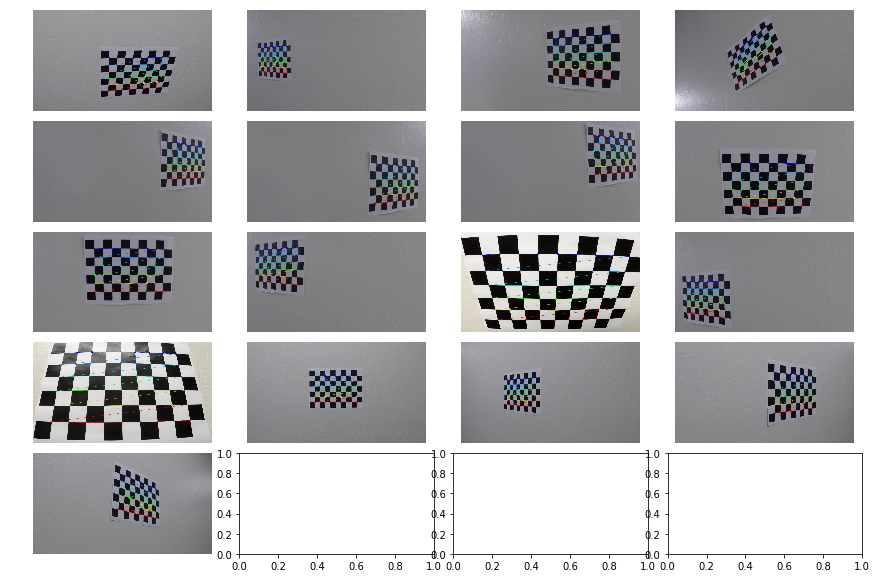

In [4]:
# Explore images after corners have been drawn
plot_images(img_with_corners)

## Step 2: Define a function to undistort images

Text(0.5,1,'UnDistorted Image')

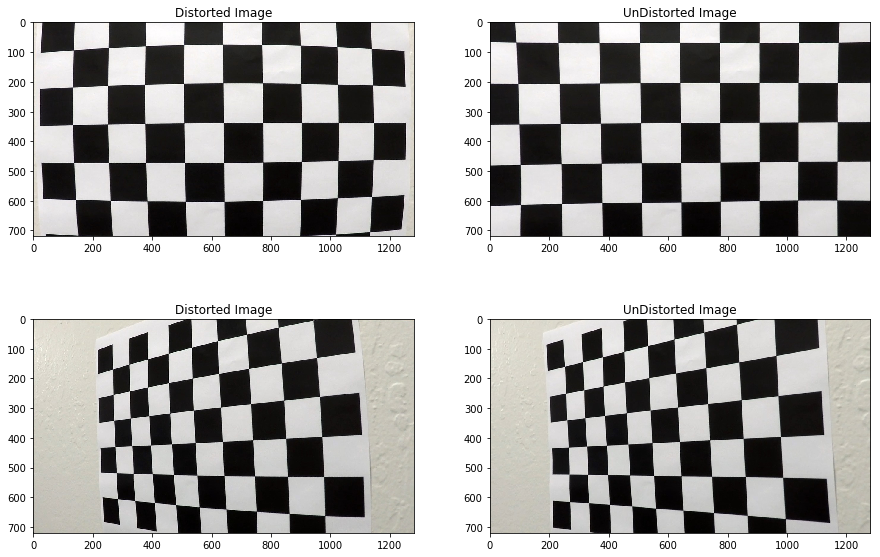

In [5]:
d_img = read_image(cal_fnames[0])
img_size = (d_img.shape[1], d_img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
def undistort_image(dimg):
    undistored = cv2.undistort(dimg, mtx, dist, None, mtx)
    return undistored

# Explore undistortion result
img = read_image('./camera_cal/calibration1.jpg')
dimg = undistort_image(img)

img2 = read_image('./camera_cal/calibration4.jpg')
dimg2 = undistort_image(img2)


f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = axs.ravel()

axs[0].imshow(img)
axs[0].set_title('Distorted Image')
axs[1].imshow(dimg)
axs[1].set_title('UnDistorted Image')

axs[2].imshow(img2)
axs[2].set_title('Distorted Image')
axs[3].imshow(dimg2)
axs[3].set_title('UnDistorted Image')

## Step 3: Warp and unwarp images

### 3.1 Explore test images

Shape of Test images (720, 1280, 3)


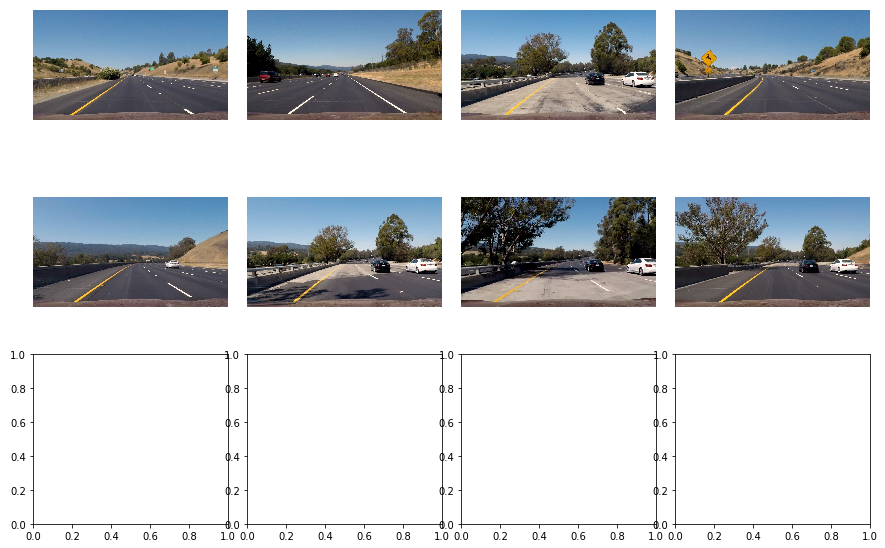

In [6]:
test_fnames = glob.glob('./test_images/*.jpg')

print("Shape of Test images", read_image(test_fnames[0]).shape)
def explore_test_images():
    images = []
    for i, test_fname in enumerate(test_fnames):
        img = read_image(test_fname)
        images.append(img)
    plot_images(images)
    

explore_test_images()    



### 3.2 Define Perspective Transform function

In [7]:
def warp_image(image, mapper):
    return cv2.warpPerspective(image, mapper, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)

def do_perspective_transform(image, src, dst):
    """
        returns warped_image, m_inv (which can be used later to invert the image)
    """
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
    warped_image = warp_image(image, m)
    return warped_image, m_inv

### 3.3 Explore various warp points

In [8]:
def visualize_warp(images, src, dst):
    f, axs = plt.subplots(len(images), 4, figsize=(15,10))
    f.subplots_adjust(hspace = .5, wspace=.1)
    axs = axs.ravel()
    i = 0
    for img in images:
        undis_image = undistort_image(img)
        warped_image, m_inv = do_perspective_transform(undis_image, src, dst)
        unwarped_image = warp_image(warped_image, m_inv)

        axs[i].imshow(img)
        axs[i].set_title('Original image')
        i += 1
        
        axs[i].imshow(undis_image)
        axs[i].set_title('Undistorted image')
        i += 1
        
        axs[i].imshow(warped_image)
        axs[i].set_title('Warped Image')
        i += 1
        
        axs[i].imshow(unwarped_image)
        axs[i].set_title('UnWarped Image')
        i += 1
        

In [9]:
testimgs = []
for test_fname in test_fnames[0:5]:
    testimgs.append(read_image(test_fname))
    
def test1_src_dest():
    height, width, _ = img.shape

    src = np.float32([(520.,410.),
                      (685.,410.), 
                      (225.,660.),
                      (1130.,660.) 
                      ])

    dst = np.float32([(400.,0),
                      (width-400.,0),
                      (400.,height),
                      (width-400.,height)])

    visualize_warp(testimgs, src, dst)
    return src, dst
        
def test2_src_dest():
    img = read_image(test_fnames[2])
    height, width, _ = img.shape

    src = np.float32([(570.,450.),
                      (705.,450.), 
                      (255.,670.),
                      (1110.,670.) 
                      ])

    dst = np.float32([(445.,0),
                      (width-445.,0),
                      (445.,height),
                      (width-445.,height)])

    visualize_warp(testimgs, src, dst)
    return src, dst

def test3_src_dest():
    img = read_image(test_fnames[2])
    height, width, _ = img.shape

    src = np.float32([(600.,450.),
                      (720.,450.), 
                      (255.,680.),
                      (1100.,680.) 
                      ])

    dst = np.float32([(445.,0),
                      (width-445.,0),
                      (445.,height),
                      (width-445.,height)])

    visualize_warp(testimgs, src, dst)    
    return src, dst

In [10]:
# src1, dst1 = test1_src_dest()

In [11]:
# src2, dst2 = test2_src_dest()

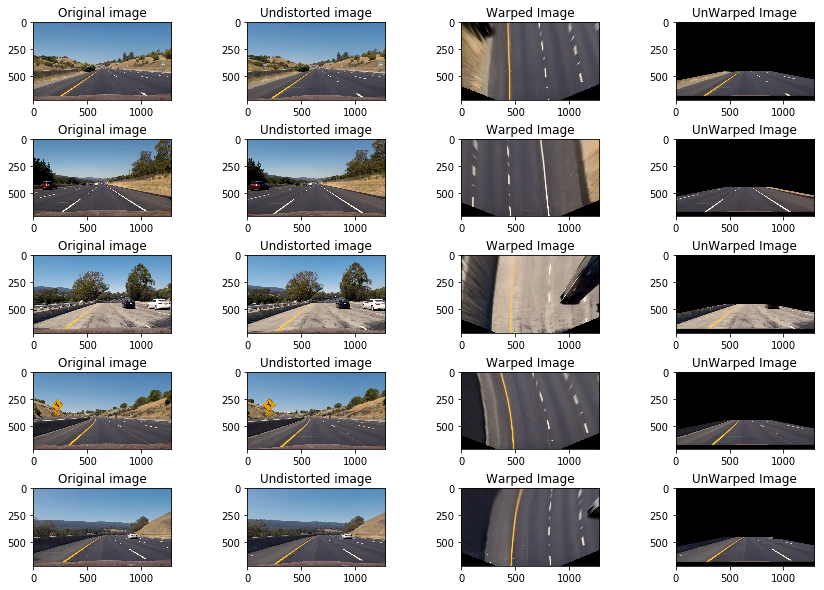

In [12]:
src3, dst3 = test3_src_dest()

### 3.4 Final warp points

In [13]:
final_src, final_dst = src3, dst3

## Step 4: Binary Thresholds for the Image

### 4.1: Create a util method to display output of threshold on 5 random images from project video

In [14]:
def get_video_images():
    video_file = './project_video.mp4'
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        return img
    
    clip = VideoFileClip(video_file)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]  
    return images

proj_video_images = get_video_images()
print(len(proj_video_images))

def get_proj_video_images():
    return proj_video_images

100%|█████████▉| 1260/1261 [00:07<00:00, 172.70it/s]

1260


In [15]:
rand_image_indices = random.sample(range(len(proj_video_images)), 5)
random_proj_images = [proj_video_images[i] for i in rand_image_indices]
    
def visualize_thresholds(thresold_func):
    f, axs = plt.subplots(len(random_proj_images), 2, figsize=(20,15))
    f.subplots_adjust(hspace = .5, wspace=.01)
    axs = axs.ravel()
    i = 0
    for img in random_proj_images:
        undis_img = undistort_image(img)
        warped_image, _ = do_perspective_transform(undis_img, final_src, final_dst)
        thresold_image = thresold_func(warped_image)
        axs[i].imshow(warped_image, cmap='gray')
        axs[i].set_title('Warped image')
        i += 1     
        axs[i].imshow(thresold_image, cmap='gray')
        axs[i].set_title('Threshold image')
        i += 1


### 4.2: Try combination of various thresholds on random sample of images

In [16]:
def magnitude_threshold(img_rgb):
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=0, thresh_max=255)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=25, thresh_max=225)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=35, thresh_max=215)
    return mag_thresh(img_rgb, sobel_kernel=9, thresh_min=35, thresh_max=235)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=40, thresh_max=200)
    # return mag_thresh(img_rgb, sobel_kernel=3, thresh_min=65, thresh_max=105)
# print()
# print("================== FINAL MAG THRESHOLD OUTPUTS ==================")    
# visualize_thresholds(magnitude_threshold)

In [17]:
def direction_threshold(img_rgb):
    # return dir_threshold(img_rgb, sobel_kernel=15, thresh_min=0, thresh_max=0.02)
    # return dir_threshold(img_rgb, sobel_kernel=15, thresh_min=0, thresh_max=0.3)
    return dir_threshold(img_rgb, sobel_kernel=11, thresh_min=0, thresh_max=0.09)

# print()
# print("================== FINAL DIRECTION THRESHOLD OUTPUTS ==================")       
# visualize_thresholds(direction_threshold)   

In [18]:
def sobel_mag_dir_threshold(img_rgb):
    mag_out = magnitude_threshold(img_rgb)
    grad_out = direction_threshold(img_rgb)
    binary_out = np.zeros_like(mag_out)
    binary_out[(grad_out==1) & (mag_out == 1)] = 1
    return binary_out
# print()
# print("================== FINAL sobel_mag_dir_threshold THRESHOLD OUTPUTS ==================")       
# visualize_thresholds(sobel_mag_dir_threshold)  


================== FINAL L + S + SOBEL THRESHOLD OUTPUTS ==================


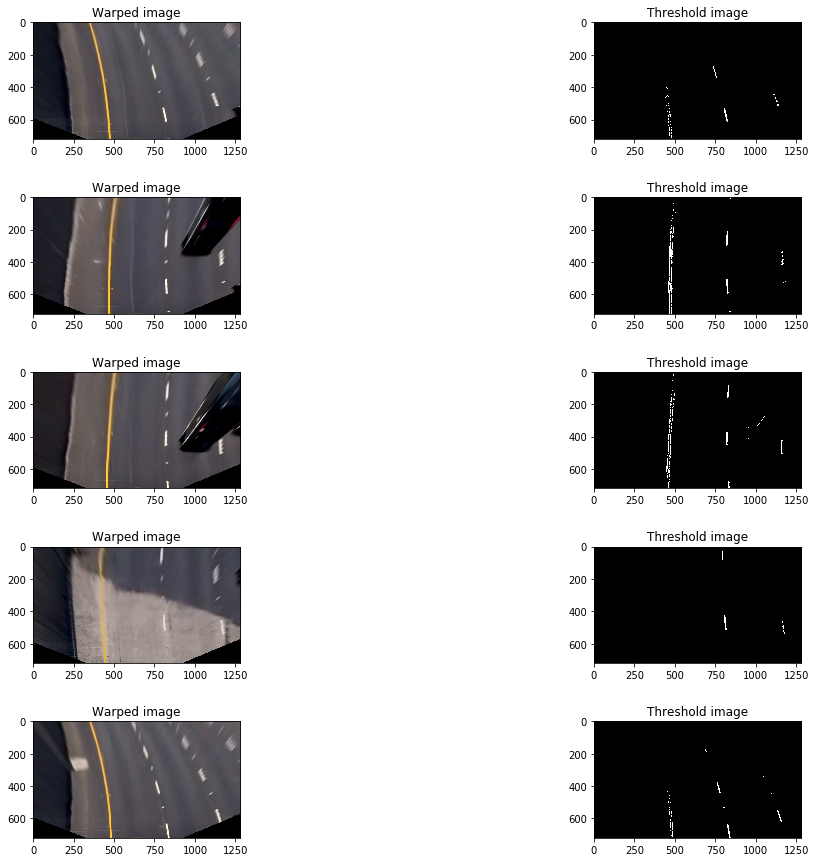

In [19]:
def l_s_grad_threshold(img_rgb):
    l_out = l_hls_threshold(img_rgb, thresh_min=210, thresh_max=255)
    s_out = s_hls_threshold(img_rgb, thresh_min=60, thresh_max=255)
    sobel_out = sobel_mag_dir_threshold(img_rgb)
    binary_out = np.zeros_like(l_out)
    binary_out[(l_out == 1)  | (s_out == 1) & (sobel_out == 1) ] = 1
    return binary_out

print()
print("================== FINAL L + S + SOBEL THRESHOLD OUTPUTS ==================")       
visualize_thresholds(l_s_grad_threshold)   


================== FINAL Yellow + White THRESHOLD OUTPUTS ==================


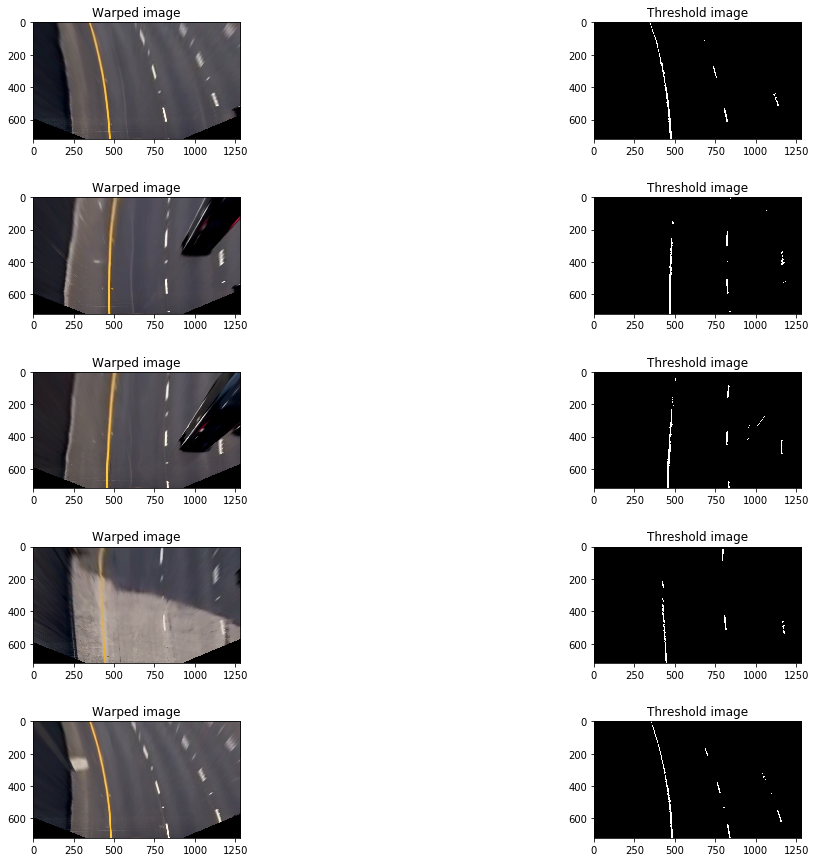

In [20]:
def y_w_grad_threshold(img_rgb):
    # Captures of yellow or white
    y_out = yellow_threshold(img_rgb)
    w_out = white_threshold(img_rgb)

    binary_out = np.zeros_like(y_out)
    binary_out[(y_out == 1)  | (w_out == 1)] = 1
    return binary_out

print()
print("================== FINAL Yellow + White THRESHOLD OUTPUTS ==================")       
visualize_thresholds(y_w_grad_threshold)   

### 4.3: Define a final combined threshold function to be used


================== FINAL COMBINED THRESHOLD OUTPUTS ==================


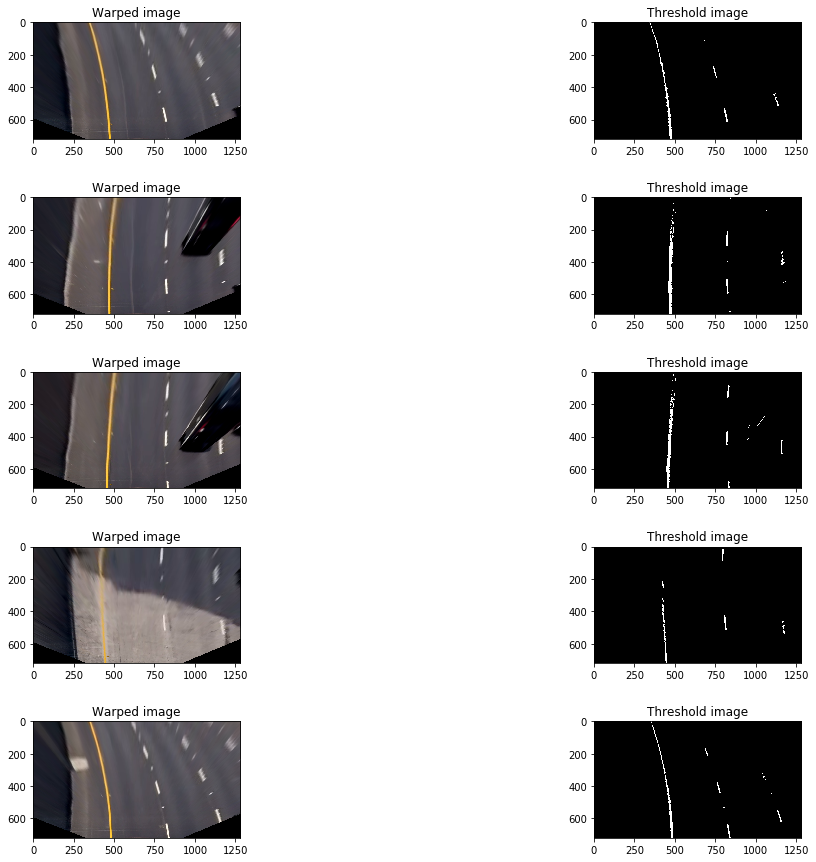

In [21]:
def combined_threshold(img_rgb):
    # Combination of (yellow or white) & (l_s_grad_threshold)
    y_w_out = y_w_grad_threshold(img_rgb)
    l_s_grad_out = l_s_grad_threshold(img_rgb)
    binary_out = np.zeros_like(y_w_out)
    binary_out[(y_w_out == 1)  | (l_s_grad_out == 1)] = 1
    return binary_out

print()
print("================== FINAL COMBINED THRESHOLD OUTPUTS ==================")       
visualize_thresholds(combined_threshold)  

## End of Step 4

### So far I built all helpers need for preprocessing image

- Undistort Image
- Warp the image for birds eye view
- Draw lane using thresholds

## Step 5: Finding Lanes

    

### 5.1: Helper method to ploy fit lane lines

In [22]:
def lane_bottom_histogram(img):
    """
        Takes histogram of the bottom half of the image
    """
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)    
    return histogram

def sliding_window_search(binary_image, draw_boxes=False):
    """
        Locate the Lane Lines and Fit a Polynomial
        This is similar to what has been taugh in lesson
    """
    histogram = lane_bottom_histogram(binary_image)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_image, binary_image, binary_image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.uint8(np.dstack((binary_image, binary_image, binary_image))*255)
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_image.shape[0] - (window+1)*window_height
        win_y_high = binary_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if draw_boxes:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
        # Draw the windows on the visualization image
#         left_lane_box = (win_xleft_low, win_y_low, win_xleft_high,win_y_high)
#         right_lane_box = (win_xright_low,win_y_low, win_xright_high,win_y_high)
#         boxes.append((left_lane_box, right_lane_box))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = None
    right_fit = None
        
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 100]
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img



In [23]:
def polyfit_lanes(binary_image, 
                  current_left_fit=None, 
                  current_right_fit=None,
                  draw_boxes=False
                 ):
    if current_left_fit is not None and current_right_fit is not None:
        nonzero = binary_image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        out_img = np.uint8(np.dstack((binary_image, binary_image, binary_image))*255)
        margin = 100
        left_lane_inds = ((nonzerox > (current_left_fit[0]*(nonzeroy**2) + current_left_fit[1]*nonzeroy + current_left_fit[2] - margin)) & 
                  (nonzerox < (current_left_fit[0]*(nonzeroy**2) + current_left_fit[1]*nonzeroy + current_left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (current_right_fit[0]*(nonzeroy**2) + current_right_fit[1]*nonzeroy + current_right_fit[2] - margin)) & 
                   (nonzerox < (current_right_fit[0]*(nonzeroy**2) + current_right_fit[1]*nonzeroy + current_right_fit[2] + margin)))  
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        left_fit = None
        right_fit = None
        
        if len(leftx) > 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(rightx) > 0:
            right_fit = np.polyfit(righty, rightx, 2)
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
        return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img
    else:
        return sliding_window_search(binary_image, draw_boxes=draw_boxes)

        

In [24]:

def get_binary_warped_image(sample_image):
        undis_img = undistort_image(sample_image)
        warped_image, _ = do_perspective_transform(undis_img, final_src, final_dst)
        binary_image = combined_threshold(warped_image)
        return binary_image

def draw_polylines(out_img, left_fit, right_fit):
        ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='red')
        plt.plot(right_fitx, ploty, color='blue')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)


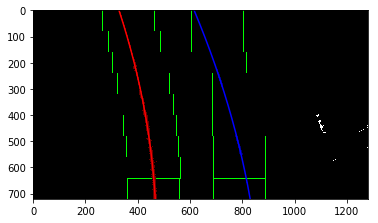

In [25]:
# Test First frame

first_frame = get_proj_video_images()[221]
binary_image = get_binary_warped_image(first_frame)
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = polyfit_lanes(binary_image, draw_boxes=True)
draw_polylines(out_img, left_fit, right_fit)

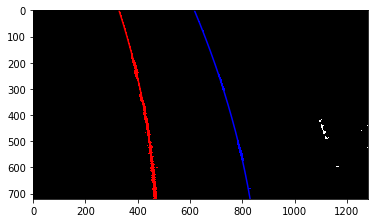

In [26]:
# Test second frame
second_frame = get_proj_video_images()[222]
binary_image = get_binary_warped_image(second_frame)
new_left_fit, new_right_fit, new_left_lane_inds, new_right_lane_inds, new_out_img = polyfit_lanes(
    binary_image, current_left_fit=left_fit, current_right_fit=right_fit)
draw_polylines(new_out_img, new_left_fit, new_right_fit)

### 5.2: Determine radius of curvature and center offset


In [27]:
def get_meters_per_pixel():
    ym_per_pix = 30.0/720.0
    xm_per_pix = 3.7/(825.0 - 445.0)
    return xm_per_pix, ym_per_pix
    
def get_curvature(binary_image, left_lane_inds, right_lane_inds):
    
    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
  
    xm_per_pix, ym_per_pix = get_meters_per_pixel()
    
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_curverad = None
    right_curverad = None
    
    if len(leftx) > 0 and len(rightx) > 0 :
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    return left_curverad, right_curverad
    
    
def get_center_offset(binary_image, left_fit, right_fit):    
    # image x midpoint - mean of left_fit and right_fit intercepts 
    if left_fit is None or right_fit is None:
        return None
    
    xm_per_pix, ym_per_pix = get_meters_per_pixel()
    
    v_height = 700
    x_left_pix = left_fit[0]*(v_height**2) + left_fit[1]*v_height + left_fit[2]
    x_right_pix = right_fit[0]*(v_height**2) + right_fit[1]*v_height + right_fit[2]
    
    mid_position = binary_image.shape[1]/2
    return ((x_left_pix + x_right_pix)/2.0 - mid_position) * xm_per_pix


In [28]:
im_frame = get_proj_video_images()[222]
binary_image = get_binary_warped_image(im_frame)
left_fit, right_fit, left_lane_inds, right_lane_inds, _ = polyfit_lanes(binary_image)
print("Curvature: ", get_curvature(binary_image, left_lane_inds, right_lane_inds))
print("Center offset: ", get_center_offset(binary_image, left_fit, right_fit))


Curvature:  (493.92428745378277, 524.76190106089962)
Center offset:  0.0578588064553


### 5.2 Define Line class which holds each lines charecteristics

In [29]:
class Pipeline():
    """
        Class to process each frame in video
    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients of current image
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
    def find_lanes(self, binary_image):
        current_left_fit = None
        current_right_fit = None
        
        if self.best_fit is not None:
            current_left_fit = self.best_fit[0]
            current_right_fit = self.best_fit[1]
        
        left_fit, right_fit, left_lane_inds, right_lane_inds, out_image = polyfit_lanes(
    binary_image, current_left_fit=current_left_fit, current_right_fit=current_right_fit)
        
        self.current_fit = [left_fit, right_fit]
        
        if left_fit is not None and right_fit is not None:
            self.recent_xfitted.append(self.current_fit)
        
        if len(self.recent_xfitted) > 5:
            self.recent_xfitted.pop(0)
        
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        self.radius_of_curvature = get_curvature(binary_image, left_lane_inds, right_lane_inds)
        self.line_base_pos = get_center_offset(binary_image, left_fit, right_fit)
        
        return out_image
    
    
    def draw_detected_lane(self, frame_img, binary_img, m_inv):
        out_img = np.copy(frame_img)
        if self.current_fit is None:
            return out_img
        
        left_fit = self.best_fit[0]
        right_fit = self.best_fit[1]
        
        # Create an image to draw the lines on
        warp_copy = np.zeros_like(binary_img).astype(np.uint8)
        color_warp = np.dstack((warp_copy, warp_copy, warp_copy))

        h,w = binary_img.shape
        
        ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

        unwarped_image = warp_image(color_warp, m_inv)
        
        # Combine the result with the original image
        image_with_lanes = cv2.addWeighted(out_img, 1, unwarped_image, 0.5, 0)

        left_curvature = self.radius_of_curvature[0]
        right_curvature = self.radius_of_curvature[1]
        font = cv2.FONT_HERSHEY_DUPLEX

        if left_curvature is not None and right_curvature is not None:
            mean_curvature = (left_curvature + right_curvature)/ 2
            curve_txt = 'Curvature: ' + str(np.round(mean_curvature,2)) + 'm'
            cv2.putText(image_with_lanes, curve_txt, (30, 60), font, 1, (0,0,0), 2)


        if self.line_base_pos is not None:
            lane_offset = self.line_base_pos
            offset_txt = 'Position Offset ' + str(np.absolute(np.round(lane_offset,4))) + 'm' + (' Right' if lane_offset > 0 else ' Left')

            cv2.putText(image_with_lanes, offset_txt, (30, 110), font, 1, (0,0,0), 2)
       
        return image_with_lanes
        

    def process_frame(self, frame_image):
        undis_frame_image = undistort_image(frame_image)
        warped_image, m_inv = do_perspective_transform(undis_frame_image, final_src, final_dst)
        binary_image = combined_threshold(warped_image)        
        self.find_lanes(binary_image)
        return self.draw_detected_lane(frame_image, binary_image, m_inv)
        
    

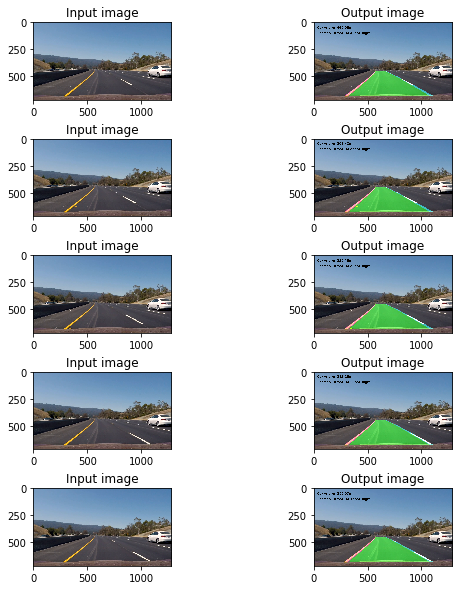

In [30]:
im_frames = get_proj_video_images()[225:230]

def test_pipeline():
    pipeline = Pipeline()
    f, axs = plt.subplots(len(im_frames), 2, figsize=(10,10))
    f.subplots_adjust(hspace = .5, wspace=.01)
    axs = axs.ravel()
    i = 0
    for img in im_frames:
        out_img = pipeline.process_frame(img)
        axs[i].imshow(img)
        axs[i].set_title('Input image')
        i += 1     
        axs[i].imshow(out_img, cmap='gray')
        axs[i].set_title('Output image')
        i += 1

test_pipeline()

In [31]:
pipeline = Pipeline()
# project_video = VideoFileClip('project_video.mp4').subclip(20,25)
project_video = VideoFileClip('project_video.mp4')
out_frames = project_video.fl_image(pipeline.process_frame)
%time out_frames.write_videofile('project_video_out.mp4', audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:04<00:00,  2.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 9min 54s, sys: 2min 8s, total: 12min 2s
Wall time: 8min 5s


In [32]:
challenge_pipeline = Pipeline()
challenge_video = VideoFileClip('challenge_video.mp4')
challenge_out_frames = challenge_video.fl_image(challenge_pipeline.process_frame)
%time challenge_out_frames.write_videofile('challenge_video_out.mp4', audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [02:32<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 3min 12s, sys: 38.4 s, total: 3min 50s
Wall time: 2min 33s
